# Performance on Low Segment Languages
The purpose of this notebook is to see if the pyAudioAnalysis library can do a better job of pulling out voice segments than wedrctvad did.

The following will be looked at:
1. FewSegmentLanguages.ipynb identified languages that had a low number of segments generated. Compare how pyAudioAnalysis does on the same files
2. Compare how pyAudioAnalysis does on files that webrtcvad did a reasonable job
3. Compare how pyAudioAnalysis does on files that contain pure instrumentals, and those that have voice over instruments. 

## Files that had few segments extracted.


In [2]:
import pandas as pd
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('~/work/pyAudioAnalysis'))
if module_path not in sys.path:
    sys.path.append(module_path)
from collections import namedtuple

from pyAudioAnalysis import audioSegmentation as aS
from pyAudioAnalysis import audioTrainTest as at
from pyAudioAnalysis import MidTermFeatures as mtf
from pyAudioAnalysis import audioBasicIO

In [5]:
# define our unittests
import unittest

def run_tests(test_invoked=''):
  default_test = (test_invoked, ) if test_invoked != '' else None
  unittest.main(argv=[''], verbosity=1, exit=False, defaultTest=default_test)

In [6]:
fd_low_segs = pd.read_csv('../../data/files_with_few_segs.csv')

Now try analysis on just one file.

In [7]:
test_file = '/media/programs/' + fd_low_segs.iloc[1000].path + fd_low_segs.iloc[1000].filename
print(test_file)

/media/programs/Programs/37/37924/A37924/PM-Copy-1001/A37924-38.wav


In [8]:
[flagsInd, classesAll, acc, CM] = aS.mid_term_file_classification(test_file, "/home/jovyan/work/pyAudioAnalysis/pyAudioAnalysis/data/models/knn_4class", "knn", True)


[0. 2.] 1
[2. 4.] 3
[4. 5.] 0
[5. 7.] 1
[7. 8.] 0
[8. 9.] 3
[ 9. 10.] 1
[10. 12.] 3
[12. 13.] 1
[13. 17.] 3
[17. 18.] 1
[18. 20.] 3
[20. 22.] 1
[22. 23.] 0
[23. 25.] 1
[25. 26.] 3
[26. 28.] 1
[28. 30.] 3
[30. 31.] 1
[31. 34.] 3
[34. 36.] 1
[36. 37.] 0
[37. 38.] 1
[38. 39.] 3
[39. 40.] 0
[40. 41.] 1
[41. 42.] 0
[42. 43.] 3
[43. 45.] 1
[45. 46.] 3
[46. 47.] 0
[47. 48.] 3
[48. 49.] 1
[49. 50.] 3
[50. 51.] 1
[51. 52.] 3
[52. 54.] 1
[54. 58.] 3
[58. 62.] 1


OK - So that is another wrinkle. There are multiple models in the code loaded. It would appear they are as follows:
- knn_4class: this uses k nearest neighbour to classify audio into speech, music, silence and other.
- knnMusicGenre6: This does not support segmentation - it determines the genre of the whole track.
- knn_speaker_10: This classifies into 10 different speakers, 5 male and 5 female using knn
- svm_rbf_4class: as for knn_4class but using an SVM algorithm
- knn_sm: uses knn to differentiate between speech and music
- svm_rbf_sm: as above but uses an SvM
- then others for male/female determination and musical genres.

So this leaves me with two choices: knn_4class and svm_rbf_4class. Are they very different- and if so which one is right?

## Algorithm Comparison
Lets compare webrtcvad, knn_4class and svm_4class on three sets of data:
1. Instrumentals
2. Files that webrtcvad did poorly on
3. Files that webrtcvad did well on

First of all get our sample data sets together.

In [9]:
def get_filename(row):
    return row.path + row.filename if row.path[-1] =='/' else row.path + '/' + row.filename
    
instrumental = pd.read_csv("../../data/instrumenal_file_segs.csv")
fsegs_4sec = pd.read_csv("/media/originals/fsegs/fseg_4_df.csv")
# I want to reduce fsegs to one row per file and a count.
fsegs_file = fsegs_4sec.apply(get_filename, axis=1)
fsegs_per_file = fsegs_file.value_counts().to_frame().reset_index()
fsegs_per_file.rename(columns={'index':'filename', 0:'segments'}, inplace=True)
good_webrtcvad = fsegs_per_file[100000:101000].copy()
poor_webrtcvad = fsegs_per_file[-1000:].copy()



In [10]:
print(f"Instrumental Records: {len(instrumental)}")
print(f"Poor performing webrtcvad Records: {len(poor_webrtcvad)}")
print(f"Well performing webrtcvad Records: {len(good_webrtcvad)}")

Instrumental Records: 10783
Poor performing webrtcvad Records: 1000
Well performing webrtcvad Records: 1000


## Reimplement mid_term_file_classification
For some bizarre reason this function prints the information you want rather than returning it. Rather than modify it in the donwloaded library I have modified it here.

In [11]:
Segment = namedtuple('Segment', ['start', 'end', 'classification'])

# re-implement a simplified version of mid_term_file_classification
def as_classification(input_file, model_name, model_type):
    """
    This function performs mid-term classification of an audio stream.
    Towards this end, supervised knowledge is used,
    i.e. a pre-trained classifier.
    ARGUMENTS:
        - input_file:        path of the input WAV file
        - model_name:        name of the classification model
        - model_type:        svm or knn depending on the classifier type
    RETURNS:
    (start, end, label), class_names
          - start, end, label:  a sequence of tuples of each segment.
          - class_names:    a string sequence of class_names used in classification:
                            class_names[i] is the name of classes[i]
    """
    
    segments = []
    labels = []
    class_names = []
    if not os.path.isfile(model_name):
        print("mtFileClassificationError: input model_type not found!")
        return segments, class_names

    # Load classifier:
    if model_type == "knn":
        classifier, mean, std, class_names, mt_win, mid_step, st_win, \
         st_step, compute_beat = at.load_model_knn(model_name)
    else:
        classifier, mean, std, class_names, mt_win, mid_step, st_win, \
         st_step, compute_beat = at.load_model(model_name)
    if compute_beat:
        print("Model " + model_name + " contains long-term music features "
                                      "(beat etc) and cannot be used in "
                                      "segmentation")
        return segments, class_names
    # load input file
    sampling_rate, signal = audioBasicIO.read_audio_file(input_file)

    # could not read file
    if sampling_rate == 0:
        return segments, class_names

    # convert stereo (if) to mono
    signal = audioBasicIO.stereo_to_mono(signal)

    # mid-term feature extraction:
    mt_feats, _, _ = \
        mtf.mid_feature_extraction(signal, sampling_rate,
                                   mt_win * sampling_rate,
                                   mid_step * sampling_rate,
                                   round(sampling_rate * st_win),
                                   round(sampling_rate * st_step))
    posterior_matrix = []

    # for each feature vector (i.e. for each fix-sized segment):
    for col_index in range(mt_feats.shape[1]):
        # normalize current feature v
        feature_vector = (mt_feats[:, col_index] - mean) / std

        # classify vector:
        label_predicted, posterior = \
            at.classifier_wrapper(classifier, model_type, feature_vector)
        labels.append(label_predicted)

        # update probability matrix
        posterior_matrix.append(np.max(posterior))
    labels = np.array(labels)

    # convert fix-sized flags to segments and classes
    segs, classes = aS.labels_to_segments(labels, mid_step)
    segments = [Segment(seg[0], seg[1], class_names[int(label)]) for seg, label in zip(segs, classes)]
    return segments, class_names

In [12]:
segments, classnames = as_classification(test_file, "/home/jovyan/work/pyAudioAnalysis/pyAudioAnalysis/data/models/knn_4class", "knn")


Now to compare like with like we want to turn the list of segments into 4 second segments.
The rule to use is that one second of anything does not count. We are dividing on second boundaries which may mean some words are partial. We want to split it into 4 second Segments of speech.

In [25]:
Epoch = namedtuple('Epoch', ['start', 'end'])
def divide_into_4sec_speech_epochs(segments, speech_epochs):
    # check for termination condition
    if len(segments) == 0:
        return speech_epochs
    
    # check for skip a segment
    seg = segments[0]
    if seg.classification != 'speech':
        return divide_into_4sec_speech_epochs(segments[1:], speech_epochs)
    
    # see if the segment has 4 seconds to take
    duration = seg.end - seg.start
    if duration < 4:
        return divide_into_4sec_speech_epochs(segments[1:], speech_epochs)
    
    speech_epochs.append(Epoch(segments[0].start, segments[0].start+4))
    segments[0] = Segment(seg.start+4, seg.end, seg.classification)
    return divide_into_4sec_speech_epochs(segments, speech_epochs)



In [11]:
class TestCreateSpeechEpochs(unittest.TestCase):

    def test_null_case(self):
        self.assertEqual([], divide_into_4sec_speech_epochs([], []))
        self.assertEqual([Epoch(0, 0)], divide_into_4sec_speech_epochs([], [Epoch(0, 0)]))

    def test_one_Segment(self):
        self.assertEqual([Epoch(0, 4)], divide_into_4sec_speech_epochs([Segment(0, 5, 'speech')], []))

    def test_reject_music(self):
        self.assertEqual([Epoch(5, 9)], divide_into_4sec_speech_epochs([
            Segment(0, 5, 'music'),
            Segment(5, 10, 'speech')], []))
        
    def test_two_epochs_one_segment(self):
        self.assertEqual([Epoch(0,4), Epoch(4,8)], divide_into_4sec_speech_epochs([Segment(0,9, 'speech')], []))

    def test_pass_epoch(self):
        self.assertEqual([Epoch(10, 14),Epoch(0,4), Epoch(4,8)], divide_into_4sec_speech_epochs([Segment(0,9, 'speech')], [Epoch(10, 14)]))

    def test_reject_complex(self):
        self.assertEqual([Epoch(5, 9), Epoch(25, 29)], divide_into_4sec_speech_epochs([
            Segment(0, 5, 'music'),
            Segment(5, 10, 'speech'),
            Segment(11, 20, 'other'),
            Segment(25, 30, 'speech') ], []))
        

run_tests('TestCreateSpeechEpochs')


......
----------------------------------------------------------------------
Ran 6 tests in 0.003s

OK


In [14]:

# This function filters out short segments that occur in the middle of longer ones
def merge_short_segments(segments):
    if len(segments) < 3:
        return segments
    
    
    seg0 = segments[0]
    seg1 = segments[1]
    seg2 = segments[2]

    # check for a merge condition
    if seg0.classification == seg2.classification:
        # check they are contiguous
        if seg0.end == seg1.start and seg1.end == seg2.start:
            # check the durations
            seg0_duration = seg0.end - seg0.start
            seg1_duration = seg1.end - seg1.start
            seg2_duration = seg2.end - seg2.start
            if seg1_duration == 1 and (seg0_duration > 1 or seg2_duration > 1):
                # we want to merge these three together
                new_segs = [Segment(seg0.start, seg2.end, seg0.classification)]
                new_segs.extend(segments[3:])
                return merge_short_segments(new_segs)

    new_segs = [seg0]
    new_segs.extend(merge_short_segments(segments[1:]))
    return new_segs


In [14]:
class TestRemoveShortSegments(unittest.TestCase):

    def test_null_case(self):
        self.assertEqual([], merge_short_segments([]))

    def test_one_segment(self):
        self.assertEqual([Segment(0, 6, 'music')], merge_short_segments([Segment(0, 6, 'music')]))

    def test_two_segments(self):
        self.assertEqual(
            [Segment(0, 6, 'music'), Segment(6, 7, 'silence')],
            merge_short_segments([Segment(0, 6, 'music'), Segment(6, 7, 'silence')]))

    def test_three_segments(self):
        self.assertEqual(
            [Segment(0, 6, 'music'), Segment(6, 7, 'silence'), Segment(7, 8, 'speech')],
            merge_short_segments([Segment(0, 6, 'music'), Segment(6, 7, 'silence'), Segment(7, 8, 'speech')]))

    def test_simple_merge(self):
        self.assertEqual(
            [Segment(0, 8, 'music')],
            merge_short_segments([Segment(0, 6, 'music'), Segment(6, 7, 'silence'), Segment(7, 8, 'music')]))

    def test_hanging_segment_merge(self):
        self.assertEqual(
            [Segment(0, 8, 'music'), Segment(8, 9, 'silence')],
            merge_short_segments([Segment(0, 6, 'music'), Segment(6, 7, 'silence'), Segment(7, 8, 'music'), Segment(8, 9, 'silence')]))

    def test_discontiguous_non_merge(self):
        self.assertEqual(
            [Segment(0, 6, 'music'), Segment(7, 8, 'silence'), Segment(8, 9, 'music')],
            merge_short_segments([Segment(0, 6, 'music'), Segment(7, 8, 'silence'), Segment(8, 9, 'music')]))

    def test_segment_too_long_to_merge(self):
        self.assertEqual(
            [Segment(0, 6, 'music'), Segment(6, 8, 'silence'), Segment(8, 9, 'music')],
            merge_short_segments([Segment(0, 6, 'music'), Segment(6, 8, 'silence'), Segment(8, 9, 'music')]))
        
    def test_compound_merge(self):
        self.assertEqual(
            [Segment(0,9,'music')],
            merge_short_segments([Segment(0, 2, 'music'), Segment(2, 3, 'silence'), Segment(3, 4, 'music'), Segment(4, 5, 'silence'), Segment(5,9, 'music')]))


run_tests('TestRemoveShortSegments')


.........
----------------------------------------------------------------------
Ran 9 tests in 0.004s

OK


In [15]:
run_tests()

...............
----------------------------------------------------------------------
Ran 15 tests in 0.008s

OK


Now for running these tests I do not actually want the segments, I just want to count them.

In [15]:
import time
import warnings
# sklearn puts out a lot of annoying warnings
warnings.filterwarnings('ignore')

class ApplyClassification:
    def __init__(self, model_type):
        self.count = 0
        model_t = model_type if model_type == 'knn' else 'svm_rbf'
        self.model = f"/home/jovyan/work/pyAudioAnalysis/pyAudioAnalysis/data/models/{model_t}_4class"
        self.model_type = model_type if model_type == 'knn' else 'svm'
        self.start_time = time.time()

    def segment(self, filename):
        if self.count % 10 == 0:
            print(f'Processing({self.count}) {time.time()-self.start_time}: {filename}')
        self.count += 1
        segments, _ = as_classification('/media/programs/' + filename, self.model, self.model_type)
        segs = merge_short_segments(segments)
        return divide_into_4sec_speech_epochs(segs, [])
    
    def __call__(self, filename):
        return len(self.segment(filename))

       

In [16]:
count_segs_knn = ApplyClassification('knn')
good_webrtcvad['knn_segs'] = good_webrtcvad.filename.apply(count_segs_knn)


Processing(0) 0.0006229877471923828: Programs/73/73980/A73980/PM-1906/A73980-008.wav


KeyboardInterrupt: 

In [ ]:
count_segs_svm = ApplyClassification('svm')
good_webrtcvad['svm_segs'] = good_webrtcvad.filename.apply(count_segs_svm)

In [37]:
good_webrtcvad.to_csv('../../data/good_webrtcvad.csv')

Lets see how many segments were found by each on files where I though webrtcvad was good.

In [38]:
print(f'webrctvad: {sum(good_webrtcvad.segments)} knn: {sum(good_webrtcvad.knn_segs)} svm: {sum(good_webrtcvad.svm_segs)}')

webrctvad: 8000 knn: 13563 svm: 16020


OK - lets see what happened with the other data sets.

In [42]:
def get_file(row):
    return row.path + row.file if row.path[-1] =='/' else row.path + '/' + row.file
    
instrumental_file = instrumental.apply(get_file, axis=1)
instrument = instrumental_file.value_counts().to_frame().reset_index()
instrument.rename(columns={'index':'filename', 0:'segments'}, inplace=True)


In [43]:

count_segs_knn = ApplyClassification('knn')
instrument['knn_segs'] = instrument.filename.apply(count_segs_knn)
count_segs_svm = ApplyClassification('svm')
instrument['svm_segs'] = instrument.filename.apply(count_segs_svm)
count_segs_knn = ApplyClassification('knn')
poor_webrtcvad['knn_segs'] = poor_webrtcvad.filename.apply(count_segs_knn)
count_segs_svm = ApplyClassification('svm')
poor_webrtcvad['svm_segs'] = poor_webrtcvad.filename.apply(count_segs_svm)

Processing(0) 0.0006053447723388672: Programs/63/63339/A63339/PM-1003/A63339-01.wav
Processing(10) 96.1436607837677: Programs/01/01901/A01901/From_CM/C01901A-01.wav
Processing(20) 155.15182852745056: Programs/80/80474/A80474/PM-0901/A80474-11.wav
Processing(30) 201.30797791481018: Programs/80/80865/A80865/PM-0907/A80865-42.wav
Processing(40) 257.2413582801819: Programs/62/62707/A62707/PM0709/A62707-27.wav
Processing(50) 305.81438279151917: Programs/62/62614/A62614/PM-0706/A62614-41.wav
Processing(60) 353.3297028541565: Programs/62/62902/A62902/PM0809/A62902-10.wav
Processing(70) 401.978173494339: Programs/66/66718/A66718/PM-2010/A66718-08.wav
Processing(80) 447.29798650741577: Programs/65/65478/A65478/PM-1703-24bit/A65478-026.wav
Processing(90) 484.1585006713867: Programs/75/75066/A75066/From_CM/A75066-05.wav
Processing(100) 520.3748934268951: Programs/35/35770/A35770/From_CM/C35770A(10).wav
Processing(110) 545.1551489830017: Programs/63/63981/A63981/PM-1212/A63981-001.wav
Processing(1

In [44]:
instrument.to_csv('../../data/instrument.csv')
poor_webrtcvad.to_csv('../../poor_webrtcvad.csv')
good_webrtcvad.to_csv('../../data/good_webrtcvad.csv')


In [17]:
instrument = pd.read_csv('../../data/instrument.csv')
poor_webrtcvad = pd.read_csv('../../poor_webrtcvad.csv')
good_webrtcvad = pd.read_csv('../../data/good_webrtcvad.csv')

In [18]:
print(f'good webrctvad: {sum(good_webrtcvad.segments)} knn: {sum(good_webrtcvad.knn_segs)} svm: {sum(good_webrtcvad.svm_segs)}')
print(f'poor webrctvad: {sum(poor_webrtcvad.segments)} knn: {sum(poor_webrtcvad.knn_segs)} svm: {sum(poor_webrtcvad.svm_segs)}')
print(f'instruments:    {sum(instrument.segments)} knn: {sum(instrument.knn_segs)} svm: {sum(instrument.svm_segs)}')


good webrctvad: 8000 knn: 13563 svm: 16020
poor webrctvad: 1000 knn: 7955 svm: 8992
instruments:    10783 knn: 1087 svm: 1054


## Validation
So svm would appear to be the best. I need to check the segments found. Lets take some example files and listen to them to determine which is best.

In [19]:
print(f'File where svm and knn found more than webrtcvad: {good_webrtcvad.iloc[0].filename}')
print(f'File where svm and knn found less than webrtcvad: {good_webrtcvad.iloc[13].filename}')

File where svm and knn found more than webrtcvad: Programs/73/73980/A73980/PM-1906/A73980-008.wav
File where svm and knn found less than webrtcvad: Programs/30/30850/A30850/From_CM/A30850-14.wav


In [14]:
knn = ApplyClassification('knn')
svm = ApplyClassification('svm')
knn_A73980 = knn.segment(good_webrtcvad.iloc[0].filename)
svm_A73980 = svm.segment(good_webrtcvad.iloc[0].filename)
knn_A39850 = knn.segment(good_webrtcvad.iloc[13].filename)
svm_A39850 = svm.segment(good_webrtcvad.iloc[13].filename)


Processing(0) 0.0005877017974853516: Programs/73/73980/A73980/PM-1906/A73980-008.wav
Processing(0) 2.914473056793213: Programs/73/73980/A73980/PM-1906/A73980-008.wav


Now we need to recover the original segments.

In [18]:
fsegs_4sec['file'] = fsegs_4sec.apply(get_filename, axis=1)


In [19]:
fsegs_A73980 = fsegs_4sec[fsegs_4sec.file == good_webrtcvad.iloc[0].filename].copy()
fsegs_A30850 = fsegs_4sec[fsegs_4sec.file == good_webrtcvad.iloc[13].filename].copy()
fsegs_A73980 = pd.DataFrame({'start': fsegs_A73980['seg_start'], 'end': fsegs_A73980['seg_stop']})
fsegs_A30850 = pd.DataFrame({'start': fsegs_A30850['seg_start'], 'end': fsegs_A30850['seg_stop']})


Listening to A73980 it:
1. starts at 0 to 44;
2. has a musical interlude from 44 to 51; and
3. continues from 51 to the end at 91.

webrtcvad:  
* started at 9.48 and had no contiguous segments. 
* The musical interlude was missed. 
* A total of 8 segments.

knn:        
* started at 3 and had continuous segments to 43;
* break from 43 to 51
* contiguous segments 51 to 87. 
* A total of 18 segments.

svm:
* started at 0 and had contiguous segments to 44;
* break 44 to 51
* contiguous segments 51 to 91
* total of 21 segments.

Listening to A30850 it:
1. starts at 0 but has many pauses.
2. has a musical interlude from 44 to 51; and
3. continues from 51 to the end at 91.

webrtcvad:  
* started at 9.48 and had no contiguous segments. 
* The musical interlude was missed. 
* A total of 8 segments.

knn:        
* started at 3 and had continuous segments to 43;
* break from 43 to 51
* contiguous segments 51 to 87. 
* A total of 18 segments.

svm:
* started at 0 and had contiguous segments to 44;
* break 44 to 51
* contiguous segments 51 to 91
* total of 21 segments.

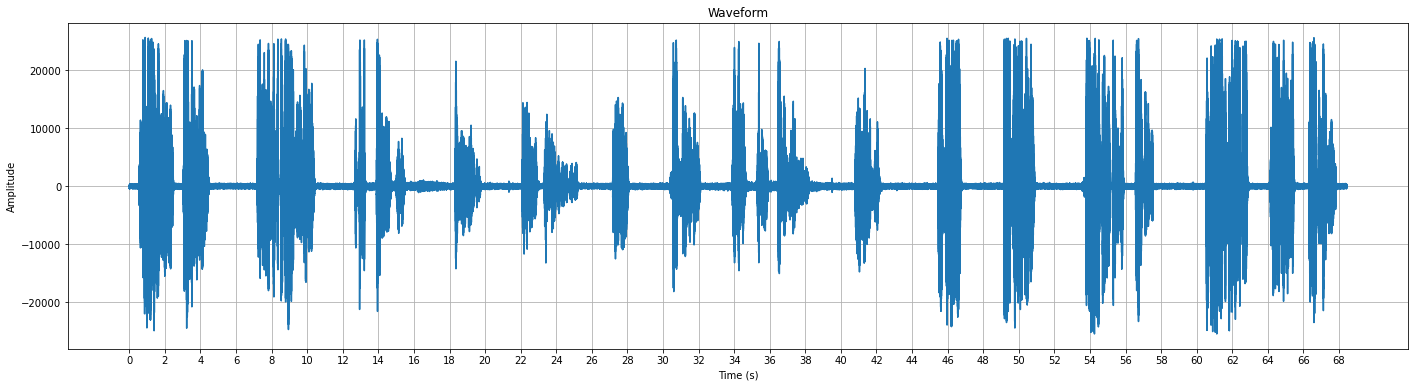

In [20]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Open the WAV file
filename = '/media/programs/' + good_webrtcvad.iloc[13].filename
with wave.open(filename, 'rb') as wav_file:
    # Get the number of frames, channels, and sample rate
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()

    # Read the data and convert to a numpy array
    wav_data = wav_file.readframes(num_frames)
    data = np.frombuffer(wav_data, dtype=np.int16)

    # Calculate the time array
    time = np.arange(num_frames) / sample_rate

# Create the plot
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(time, data)
ax.set(xlabel='Time (s)', ylabel='Amplitude', title='Waveform')
ax.grid('x', which='major')
ax.set_xticks(np.arange(0,70,2))
plt.show()


The file A30850 is problematic as it has many short bursts of speech intermixed with silence. It is very difficult to hear where all the pauses are. I have therefore plotted the wav file.
From this plot is is apparent that speech is in:
* 0-4
* 7-11
* 13-15.5
* 18-20
* 22-25
* 27-28
* 30-32
* 34-38
* 41-42
* 45-47
* 49-51
* 53-57
* 60-63
* 64-68

Which means webrtcvad did a pretty good job.
knn missed 34-38 but the rest is acceptable
svm missed 34-38 and got one more segment than knn right at the end

34-38 is very bitsy. I suspect the actual speech was less than a second meaning that the silence merged with it. It is probably better to exclude it.

I believe this means that svm is the all round winner. Lets proceed to forming a database using the svm model.

Now there is a silence removal function. This effectively detects the silence to other boundaries. Can this be used to enhance the extraction?

In [21]:
[Fs, x] = audioBasicIO.read_audio_file('/media/programs/' + good_webrtcvad.iloc[13].filename)
segments = aS.silence_removal(x, Fs, 0.02, 0.02, smooth_window=1.0, weight=0.3)

which is a pretty accurate analysis of a crappy file. How can this be used?

First we need to break up midterm classify a bit more to stop it reading files and start taking audio as input. Next we need to work out what algorithm we are going to use to handle broken up files. Do we keep silences? Do we start speech on a silence? Do we want to keep the original cadence? ie do not remove silences but reject segments that contain too much silence?

General rules: 
1. No more than 25% of segment should contain silence.
2. Segment starts with at least 0.75s of speech
3. Segment starts on a speech pause boundary (0.2s)

what are the effects of applying these rules? I am not sure about rule 3. We need to test the effects of changing the boundaries of each rule. They are not dissimilar to the rules I wrote for vad. I can possibly reuse vad. 

Before I do anything however, I need to treat non-voice the same as silence.

That, however, is enough for this notebook. The new algorithm is developed in DevelopASSegmentation.ipynb.